In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurements = Base.classes.measurement
Stations = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
first_row = session.query(Measurements).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x19558e81240>,
 'date': '2010-01-01',
 'tobs': 65.0,
 'station': 'USC00519397',
 'id': 1,
 'prcp': 0.08}

In [11]:
first_row = session.query(Stations).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x19558f09840>,
 'id': 1,
 'latitude': 21.2716,
 'elevation': 3.0,
 'longitude': -157.8168,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US'}

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
session.query(Measurements.date).order_by(Measurements.date.desc()).first()

('2017-08-23',)

In [46]:
last = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
last_date = (last.date)
# yr = func.strftime("%m", last.date)
# type(yr)
last_date 
# last_date.strftime("%m")
# strftime('%Y %m %d','now')
# date_object = dt.strptime(last_date, '%m-%d-%Y').date()
# print(type(date_object))
# print(date_object)  # printed in default forma

last_date_dt = dt.datetime.strptime(last_date, '%Y-%m-%d').date()

year_prior = last_date_dt.year - 1
year_prior_date = dt.datetime(year_prior, last_date_dt.month, last_date_dt.day).date()
print(year_prior_date)


2016-08-23


In [ ]:
date_str = '2011-04-01'
date_object = dt.datetime.strptime(last_date, '%Y-%m-%d').date()
date_object.strftime("%y") 
# date_object.year - 1
new_year = date_object.year - 1
print(dt.datetime(new_year, 1, 31).date())
new_year = datetime_str.year - 1
print(dt.datetime(new_year, datetime_str.month, datetime_str.day).date())
type(dt.datetime(new_year, datetime_str.month, datetime_str.day).date())
# strftime("%y", datetime_str) = new_year
# datetime_str.day

In [50]:
last_12_mo = session.query(Measurements).filter(Measurements.date > year_prior_date)
last_12_mo.first().__dict__
last_12_mo.count()

2223

In [52]:
allrows = session.query(Measurements)
allrows.count()

19550

In [55]:
m_clean = allrows.filter(Measurements.prcp != "")
m_clean.count()

18103

In [52]:
m_clean2 = last_12_mo.filter(Measurements.prcp != "")
m_clean2.count()

2015

In [62]:
# tabl = session.query(Measurements)
tabl = m_clean
for row in tabl:
    print(row.prcp, row.date)

0.08 2010-01-01
0.0 2010-01-02
0.0 2010-01-03
0.0 2010-01-04
0.06 2010-01-07
0.0 2010-01-08
0.0 2010-01-09
0.0 2010-01-10
0.01 2010-01-11
0.0 2010-01-12
0.0 2010-01-14
0.0 2010-01-15
0.0 2010-01-16
0.0 2010-01-17
0.0 2010-01-18
0.0 2010-01-19
0.0 2010-01-20
0.0 2010-01-21
0.0 2010-01-22
0.0 2010-01-23
0.01 2010-01-24
0.0 2010-01-25
0.04 2010-01-26
0.12 2010-01-27
0.0 2010-01-28
0.03 2010-01-31
0.01 2010-02-01
0.01 2010-02-04
0.0 2010-02-05
0.0 2010-02-06
0.0 2010-02-07
0.0 2010-02-08
0.0 2010-02-09
0.0 2010-02-11
0.02 2010-02-12
0.01 2010-02-13
0.0 2010-02-14
0.0 2010-02-15
0.0 2010-02-16
0.0 2010-02-17
0.03 2010-02-20
0.0 2010-02-21
0.0 2010-02-22
0.0 2010-02-23
0.0 2010-02-24
0.0 2010-02-25
0.0 2010-02-26
0.0 2010-02-28
0.01 2010-03-01
0.0 2010-03-02
0.0 2010-03-03
0.12 2010-03-04
0.08 2010-03-05
0.03 2010-03-06
0.0 2010-03-07
0.43 2010-03-08
0.06 2010-03-09
0.0 2010-03-12
0.0 2010-03-13
0.0 2010-03-14
0.06 2010-03-15
0.0 2010-03-17
0.0 2010-03-18
0.0 2010-03-21
0.0 2010-03-22
0.0 20

In [53]:
dates_list = []
precipitation_list = []
# for row in session.query(Measurements.prcp): 
for row in m_clean2: 
    dates_list.append(row.date) 
    precipitation_list.append(row.prcp)     

# forGraph = pd.Dataframe({"precip" : precipitation_list})        
len(dates_list), len(precipitation_list)


(2015, 2015)

In [66]:
# stadtes_df = pd.DataFrame(
#     {'prec' : [session.query(Measurements.prcp)]}
# )
df = pd.DataFrame(
    {"date" : dates_list,
    "precp" : precipitation_list}
)
# df.set_index('date', inplace=True)  # do i want an index?
df

,date,precp
0,2016-08-24,0.08
1,2016-08-25,0.08
2,2016-08-26,0.00
3,2016-08-27,0.00
4,2016-08-28,0.01
...,...,...
2010,2017-08-17,0.13
2011,2017-08-19,0.09
2012,2017-08-21,0.56
2013,2017-08-22,0.50


In [67]:
sorted_df = df.sort_values('date')
sorted_df.head(10)

,date,precp
0,2016-08-24,0.08
1024,2016-08-24,1.22
700,2016-08-24,2.28
1688,2016-08-24,1.45
358,2016-08-24,2.15
1337,2016-08-24,2.15
1025,2016-08-25,0.21
1,2016-08-25,0.08
964,2016-08-25,0.00
1338,2016-08-25,0.06


<Axes: >

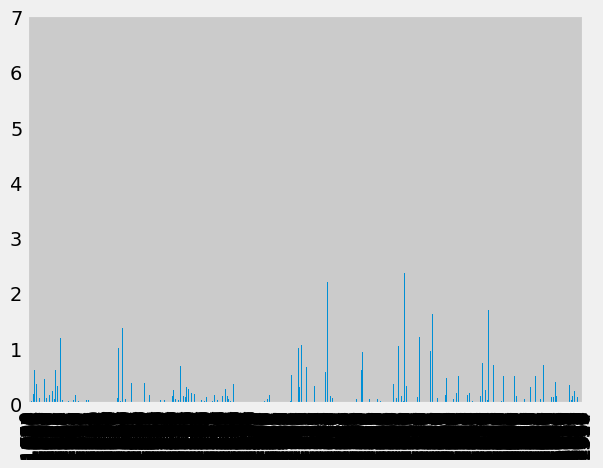

In [68]:
sorted_df['precp'].plot(kind = 'bar')

<BarContainer object of 2015 artists>

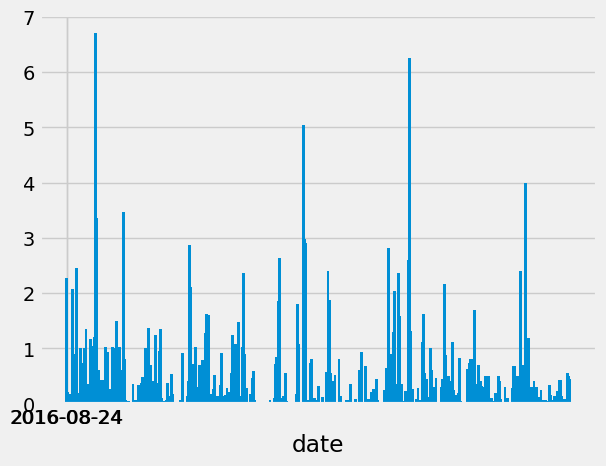

In [76]:
x_val = sorted_df['date']
y_val = sorted_df['precp']
plt.xticks(rotation = 90, np.arange(0,1,.5))
plt.xlabel('date')
plt.bar(x_val, y_val, width=2)

Text(0, 0.5, 'Inches')

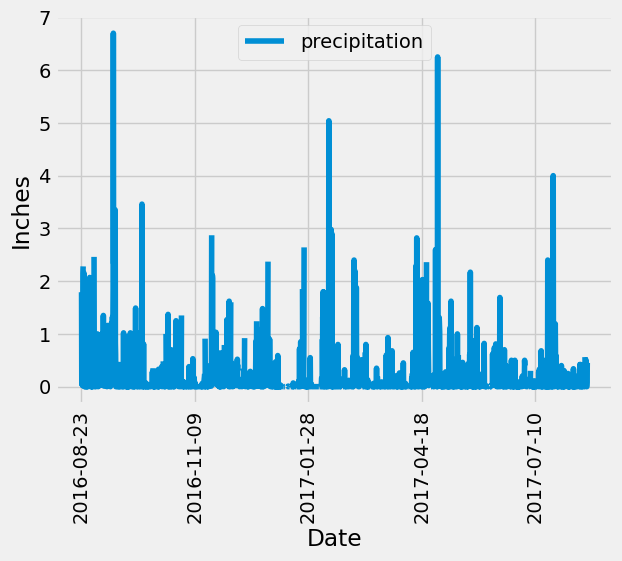

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.


# Perform a query to retrieve the data and precipitation scores


# Save the query results as a Pandas DataFrame. Explicitly set the column names


# Sort the dataframe by date


# Use Pandas Plotting with Matplotlib to plot the data


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset


[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


[(54.0, 85.0, 71.66378066378067)]

Text(0.5, 4.183333333333314, 'Temperature')

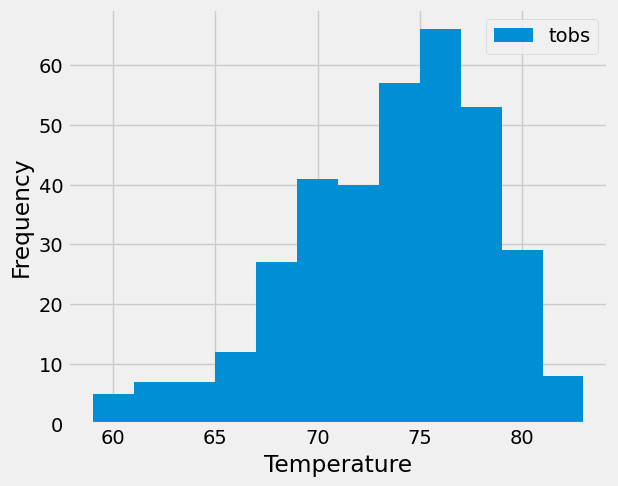

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close Session

In [16]:
# Close Session
session.close()